In [15]:
import random
import numpy as np
from time import time
import inspyred
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

In [274]:
def create_lamp_grid(grid_size, problem_size):
    da = 1/ grid_size
    r2 = 1 / problem_size / np.pi
    r = np.sqrt(r2)
    N = int(r * grid_size)
    lamp_grid = np.zeros((2*N+1, 2*N+1))
    for i in range(2*N+1):
        for j in range(2*N+1):
            x = (i-N) * da
            y = (j-N) * da
            if x**2 + y**2 <= r2:
                lamp_grid[i,j] = 1
    return lamp_grid

In [275]:
# Function to calculate the enlightened and overlap area
def calculate_areas(lamps, grid_size, problem_size, lamp_grid):
    r2 = 1 / problem_size / np.pi
    r = np.sqrt(r2)
    rN = lamp_grid.shape[0]
    extra = rN // 2
    # Initialize the grid
    tot_grid = np.zeros((grid_size + 2 * extra, grid_size + 2 * extra))
    
    # Illuminate the grid with each lamp
    for x, y in lamps:
        # Calculate the index of the lamp in the grid
        x_min = max(0, int(x * grid_size)-1)
        y_min = max(0, int(y * grid_size)-1)
        tot_grid[x_min:x_min+rN, y_min:y_min+rN] += lamp_grid

    # Remove the extra rows and columns
    tot_grid = tot_grid[extra:-extra, extra:-extra]
    # Count the enlightened and overlap area
    enlightened_area = np.sum(tot_grid > 0) / grid_size**2
    overlap_area = 1 / problem_size * len(lamps) - enlightened_area

    return enlightened_area, overlap_area

In [81]:
test_N = 3000
mat = create_lamp_grid(test_N, 3)
mat.shape

(1955, 1955)

In [82]:
lamps = [(0.25, 0.25), (0.75, 0.75), (0.25, 0.75), (0.75, 0.25)]
enlightened_area, overlap_area = calculate_areas(lamps, test_N, 3, mat)
print("Enlightened area:", enlightened_area)
print("Overlap area:", overlap_area)

Enlightened area: 0.9872208888888889
Overlap area: 0.34611244444444433


In [83]:
# The Evaluator
def evaluator_lamp(candidates, args):
    fitness = []
    problem_size = args.get('problem_size', 4)
    grid_size = args.get('grid_size', 1000)
    weight_overlap = args.get('weight_overlap', 1)
    lamp_grid = args.get('lamp_grid')
    
    for candidate in candidates:
        enlightened_area, overlap_area = calculate_areas(candidate, grid_size, problem_size, lamp_grid)
        fitness.append((enlightened_area - weight_overlap * overlap_area))
    return fitness

In [84]:
# The Generator
def generator_lamp(random, args):
    problem_size = args.get('problem_size')
    number_lamps = random.randint(problem_size, problem_size*3)
    return [(random.uniform(0, 1), random.uniform(0, 1)) for _ in range(number_lamps)] 

In [85]:
# The Bounder
def bound_lamp(candidate, args):
    for i, c in enumerate(candidate):
        x = max(min(c[0], 1), 0)
        y = max(min(c[1], 1), 0)
        candidate[i] = (x, y)
    return candidate
bound_lamp.lower_bound = itertools.repeat(0)
bound_lamp.upper_bound = itertools.repeat(1)

In [86]:
# The Observer
def observer_lamp(population, num_generations, num_evaluations, args):
    avg_len = np.mean([len(c.candidate) for c in population])
    best = max(population)
    print('{0:6} -- {1} : {2}'.format(num_generations, best.fitness, avg_len))

In [87]:
# Custom mutation operator
def mutate_lamp(random, candidates, args):
    mut_rate = args.setdefault('mutation_rate', 0.1)
    problem_size = args.get('problem_size')
    bounder = args['_ec'].bounder
    for i, cs in enumerate(candidates):
        for j, (c, lo, hi) in enumerate(zip(cs, bounder.lower_bound, bounder.upper_bound)):
            if random.random() < mut_rate:
                xi = random.random()
                if xi < 0.5:
                    # Change the position of the lamp
                    x = c[0] + random.gauss(0, 0.1) * (hi - lo)
                    y = c[1] + random.gauss(0, 0.1) * (hi - lo)
                    candidates[i][j] = (x, y)
                elif xi < 0.75 and len(cs) < 3 * problem_size:
                    # Add a new lamp
                    cs.append((random.uniform(0, 1), random.uniform(0, 1)))
                elif len(cs) > problem_size:
                    # Remove a lamp
                    index = random.randint(0, len(cs)-1)
                    del cs[index]
        candidates[i] = bounder(candidates[i], args)
    return candidates

In [88]:
# Custom crossover operator
def crossover_lamp(random, mom, dad, args):
    crossover_rate = args.setdefault('crossover_rate', 1.0)
    children = []
    
    if random.random() < crossover_rate:
        bro = copy.copy(dad)
        sis = copy.copy(mom)
        length = min(len(mom), len(dad))
        index = random.randint(0, length-1)
        child1 = bro[:index] + sis[index:]
        child2 = sis[:index] + bro[index:]
        children.append(child1)
        children.append(child2)
    else:
        children.append(mom)
        children.append(dad)
    return children

In [89]:
def my_crossover(random, candidates, args):
    if len(candidates) % 2 == 1:
        candidates = candidates[:-1]
    moms = candidates[::2]
    dads = candidates[1::2]
    children = []
    for i, (mom, dad) in enumerate(zip(moms, dads)):
        crossover_lamp.index = i
        offspring = crossover_lamp(random, mom, dad, args)
        for o in offspring:
            children.append(o)
    return children

In [95]:
rand = random.Random()
rand.seed(39)
my_ec = inspyred.ec.EvolutionaryComputation(rand)
#my_ec.selector = inspyred.ec.selectors.tournament_selection
my_ec.variator = [my_crossover, 
                  mutate_lamp]
my_ec.replacer = inspyred.ec.replacers.plus_replacement
my_ec.observer = observer_lamp
my_ec.terminator = [inspyred.ec.terminators.evaluation_termination
                    ,inspyred.ec.terminators.average_fitness_termination]

In [93]:
problem_size = 5
grid_size = 1500
lamp_grid = create_lamp_grid(grid_size, problem_size)

In [96]:
final_pop = my_ec.evolve(generator = generator_lamp,
                         evaluator = evaluator_lamp,
                         pop_size = 100,
                         bounder = bound_lamp,
                         max_evaluations = 5000,
                         num_selected = 50,
                         crossover_rate = 1,
                         mutation_rate = 0.5,
                         # Custom args
                         problem_size = problem_size,
                         grid_size = grid_size,
                         lamp_grid = lamp_grid,
                         weight_overlap = 1)
print('Terminated due to {0}.'.format(my_ec.termination_cause))
final_pop.sort(reverse=True)
print(final_pop[0])

     0 -- 0.3749093333333333 : 8.92
     1 -- 0.4399964444444442 : 6.64
     2 -- 0.5646675555555556 : 5.84
     3 -- 0.5646675555555556 : 5.69
     4 -- 0.5646675555555556 : 5.38
     5 -- 0.5646675555555556 : 5.32
     6 -- 0.5646675555555556 : 5.28
     7 -- 0.612832888888889 : 5.25
     8 -- 0.612832888888889 : 5.23
     9 -- 0.612832888888889 : 5.17
    10 -- 0.612832888888889 : 5.13
    11 -- 0.612832888888889 : 5.09
    12 -- 0.612832888888889 : 5.08
    13 -- 0.612832888888889 : 5.1
    14 -- 0.6342595555555555 : 5.08
    15 -- 0.6342595555555555 : 5.07
    16 -- 0.6411119999999999 : 5.04
    17 -- 0.6411119999999999 : 5.05
    18 -- 0.6411119999999999 : 5.01
    19 -- 0.6411119999999999 : 5.01
    20 -- 0.6411119999999999 : 5.02
    21 -- 0.6411119999999999 : 5.02
    22 -- 0.6411119999999999 : 5.01
    23 -- 0.6411119999999999 : 5.0
    24 -- 0.641664 : 5.0
    25 -- 0.641664 : 5.0
    26 -- 0.641664 : 5.0
    27 -- 0.6743591111111111 : 5.0
    28 -- 0.6743591111111111 : 5.0


In [260]:
def plot_lamps(candidate, problem_size):
    fig, ax = plt.subplots(figsize=(6, 6))
    # ax.axis('off')  # turn off the axis
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    # plot the best candidate
    radius = np.sqrt(1 / problem_size / np.pi)
    for (x, y) in candidate: 
        circle = patches.Circle((x, y), radius, edgecolor='b', facecolor='none')
        ax.add_patch(circle)
        ax.plot(x, y, 'ro')

    plt.savefig('lamp_positions.png')

In [117]:
# Calculate the number of length of final population
D = {}
for f in final_pop:
    if len(f.candidate) in D:
        D[len(f.candidate)] += 1
    else:
        D[len(f.candidate)] = 1
print(D)

{5: 100}


In [118]:
enlightened_area, overlap_area = calculate_areas(final_pop[0].candidate, grid_size, problem_size, lamp_grid)
print("Enlightened area:", enlightened_area)
print("Overlap area:", overlap_area)

Enlightened area: 0.855668
Overlap area: 0.14433200000000002


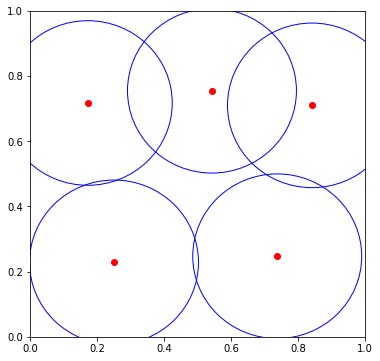

In [119]:
plot_lamps(final_pop[0].candidate, problem_size)

## Multi-Objective

In [120]:
# The Evaluator
def evaluator_lamp_multi_objective(candidates, args):
    fitness = []
    problem_size = args.get('problem_size', 4)
    grid_size = args.get('grid_size', 1000)
    lamp_grid = args.get('lamp_grid')
    
    for candidate in candidates:
        enlightened_area, _ = calculate_areas(candidate, grid_size, problem_size, lamp_grid)
        fitness.append(inspyred.ec.emo.Pareto( [-len(candidate), enlightened_area] ))
    return fitness

In [121]:
rand = random.Random()
rand.seed(39)
nsga2 = inspyred.ec.emo.NSGA2(rand)
nsga2.terminator = inspyred.ec.terminators.evaluation_termination
nsga2.variator = [my_crossover, 
                  mutate_lamp]
nsga2.observer = observer_lamp

In [122]:
problem_size = 5
grid_size = 1500
lamp_grid = create_lamp_grid(grid_size, problem_size)

In [123]:
final_pareto_front = nsga2.evolve(generator = generator_lamp,
                                  evaluator = evaluator_lamp_multi_objective,
                                  pop_size = 100,
                                  bounder = bound_lamp,
                                  max_evaluations = 5000,
                                  num_selected = 100,
                                  crossover_rate = 1,
                                  mutation_rate = 0.8,
                                  # Custom args
                                  problem_size = problem_size,
                                  grid_size = grid_size,
                                  lamp_grid = lamp_grid)
print('Terminated due to {0}.'.format(nsga2.termination_cause))

     0 -- [-6, 0.7238364444444444] : 8.92
     1 -- [-11, 0.9480417777777778] : 9.28
     2 -- [-11, 0.9480417777777778] : 9.41
     3 -- [-11, 0.9480417777777778] : 9.63
     4 -- [-11, 0.9480417777777778] : 9.67
     5 -- [-11, 0.9480417777777778] : 9.66
     6 -- [-11, 0.9480417777777778] : 9.67
     7 -- [-7, 0.8904146666666667] : 9.69
     8 -- [-7, 0.8904146666666667] : 9.69
     9 -- [-7, 0.8904146666666667] : 9.68
    10 -- [-7, 0.8904146666666667] : 9.55
    11 -- [-7, 0.8904146666666667] : 9.65
    12 -- [-7, 0.8904146666666667] : 9.69
    13 -- [-7, 0.8904146666666667] : 9.73
    14 -- [-7, 0.8904146666666667] : 9.69
    15 -- [-6, 0.8646773333333333] : 9.73
    16 -- [-6, 0.8646773333333333] : 9.69
    17 -- [-6, 0.8646773333333333] : 9.72
    18 -- [-6, 0.8646773333333333] : 9.72
    19 -- [-6, 0.8646773333333333] : 9.72
    20 -- [-6, 0.8646773333333333] : 9.74
    21 -- [-6, 0.8646773333333333] : 9.75
    22 -- [-6, 0.8646773333333333] : 9.76
    23 -- [-6, 0.86467733333

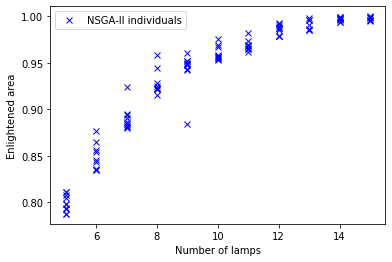

In [131]:
x_nsga2 = [ -individual.fitness[0] for individual in final_pareto_front ]
y_nsga2 = [ individual.fitness[1] for individual in final_pareto_front ]
plt.plot(x_nsga2, y_nsga2, 'bx', label="NSGA-II individuals")
plt.xlabel("Number of lamps")
plt.ylabel("Enlightened area")
plt.legend(loc="best")

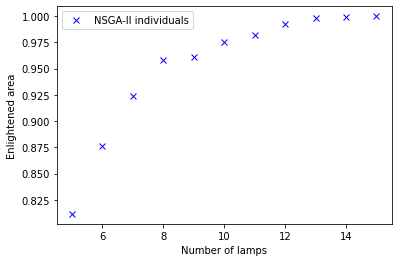

In [132]:
# Select the best individual for each number of lamps
D = {}
for f in final_pareto_front:
    N = len(f.candidate) 
    if N in D:
        if D[N].fitness[1] < f.fitness[1]:
            D[N] = f
    else:
        D[N] = f
x_best = [ -individual.fitness[0] for individual in D.values() ]
y_best = [ individual.fitness[1] for individual in D.values() ]
plt.plot(x_best, y_best, 'bx', label="NSGA-II individuals")
plt.xlabel("Number of lamps")
plt.ylabel("Enlightened area")
plt.legend(loc="best")

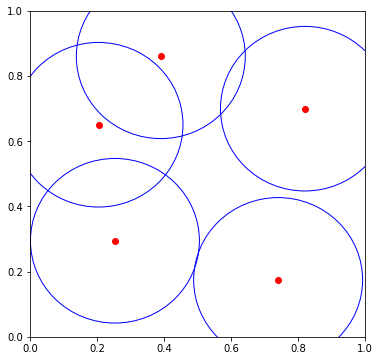

In [135]:
plot_lamps(D[5].candidate, problem_size)

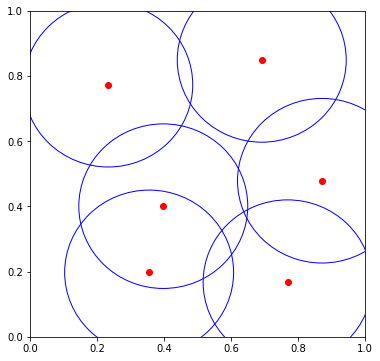

In [136]:
plot_lamps(D[6].candidate, problem_size)

## Parisian Evolution

For the lamps problem, the PE has been implemented as follows. An individual represents a lamp, its genome is its $(x, y)$ position, plus a third element, $e$, that can assume values 0 or 1 (on/off switch). Lamps with $e=1$ are "on" (expressed) and contribute to the global solution, while lamps with $e=0$ do not.

In [133]:
# The PE generator
def PE_generator(random, args):
    return [random.uniform(0, 1), random.uniform(0, 1), random.randint(0, 1)]

In [134]:
# The Bounder
def PE_bound(candidate, args):
    x = max(min(candidate[0], 1), 0)
    y = max(min(candidate[1], 1), 0)
    z = max(min(candidate[2], 1), 0)
    z = round(z)
    return [x, y, z]
bound_lamp.lower_bound = itertools.repeat(0)
bound_lamp.upper_bound = itertools.repeat(1)

In [ ]:
# The Selector


## Group Evolution

In [31]:
# The individual generator
def GE_i_generator(random, args):
    return (random.uniform(0, 1), random.uniform(0, 1))

In [176]:
# The group generator
def GE_g_generator(random, args):
    num_individuals = args.get('num_individuals')
    bound = args.get('bound_groups')
    num_groups = args.get('num_groups')
    
    Times = [1] * num_individuals
    cs = list(range(num_individuals))
    groups = []
    groups_set = set()
    
    i = 0
    while i < num_groups:
        num_lamps = random.randint(bound[0], bound[1])
        Weights = [1 / (Times[lamp] ** 2) for lamp in cs]
        probabilities = [weight / sum(Weights) for weight in Weights]
        chosen_lamps = np.random.choice(cs, size=num_lamps, replace=False, p=probabilities)
        chosen_lamps.sort()
        chosen_lamps = tuple(chosen_lamps)
        if chosen_lamps not in groups_set:
            groups.append([None, chosen_lamps])
            groups_set.add(chosen_lamps)
            for lamp in chosen_lamps:
                Times[lamp] += 1
            i += 1
    return groups

In [188]:
# The group evaluator
def GE_g_evaluator(groups, lamp_grid, index_to_cs, fitness_individuals, args):
    grid_size = args.get('grid_size')
    problem_size = args.get('problem_size')
    weight_overlap = args.get('weight_overlap')
    
    for group in groups:
        if group[0] is None:
            lamps = [index_to_cs[lamp] for lamp in group[1]]
            enlightened_area, overlap_area = calculate_areas(lamps, grid_size, problem_size, lamp_grid)
            group[0] = enlightened_area - weight_overlap * overlap_area
            for lamp in group[1]:
                if lamp not in fitness_individuals:
                    fitness_individuals[lamp] = group[0]
                else:
                    fitness_individuals[lamp] = max(fitness_individuals[lamp], group[0])
    return groups, fitness_individuals

In [139]:
def slaughter_groups(groups, args):
    num_groups = args.get('num_groups')
    # Slaughtering of groups
    groups.sort(key=lambda x: x[0], reverse=True)
    groups = groups[:num_groups]
    return groups

def slaughter_individuals(groups, index_to_cs, args):
    # Slaughtering of individuals
    used_cs = {index : False for index in index_to_cs}
    for group in groups:
        for cs in group[1]:
            used_cs[cs] = True
    # delete the individuals that are not used
    for index in sorted(used_cs, reverse=True):
        if not used_cs[index]:
            del index_to_cs[index]
    return index_to_cs

In [158]:
def GE_g_operator(random, parents, groups_set, index_to_cs, args):
    offspring_size = args.get('offspring_size')
    mutation_rate = args.get('mutation_rate')
    crossover_rate = args.get('crossover_rate')
    bound_groups = args.get('bound_groups')
    
    # Crossover
    random.shuffle(parents)
    
    if len(parents) % 2 == 1:
        parents = parents[:-1]
    moms = parents[::2]
    dads = parents[1::2]
    children = []
    
    for i, (mom, dad) in enumerate(zip(moms, dads)):
        if random.random() < crossover_rate:
            group1, group2 = list(mom[1]), list(dad[1])
            index1 = random.randint(0, len(group1)-1)
            index2 = random.randint(0, len(group2)-1)
            group1[index1], group2[index2] = group2[index2], group1[index1]
            group1.sort(), group2.sort()
            c1, c2 = tuple(group1), tuple(group2)
            if c1 not in groups_set:
                children.append([None, c1])
                groups_set.add(c1)
            if c2 not in groups_set:
                children.append([None, c2])
                groups_set.add(c2)
    
    # Adding-mutation
    set_cs = set(index_to_cs.keys())
    for group in children:
        if len(group[1]) < bound_groups[1] and random.random() < mutation_rate:
            lamp_added = random.choice(list(set_cs - set(group[1])))
            new_group = list(group[1])
            new_group.append(lamp_added)
            new_group.sort()
            new_group = tuple(new_group)
            if new_group not in groups_set:
                children.append([None, new_group])
                groups_set.add(new_group)
    
    # Removing-mutation
    for group in children:
        if len(group[1]) > bound_groups[0] and random.random() < mutation_rate:
            lamp_removed = random.choice(group[1])
            new_group = list(group[1])
            new_group.remove(lamp_removed)
            new_group = tuple(new_group)
            if new_group not in groups_set:
                children.append([None, new_group])
                groups_set.add(new_group)
    
    # Replacement-mutation
    for group in children:
        if random.random() < mutation_rate:
            lamp_removed = random.choice(group[1])
            lamp_added = random.choice(list(set_cs - set(group[1])))
            new_group = list(group[1])
            new_group.remove(lamp_removed)
            new_group.append(lamp_added)
            new_group.sort()
            new_group = tuple(new_group)
            if new_group not in groups_set:
                children.append([None, new_group])
                groups_set.add(new_group)

    return children, groups_set

In [226]:
def GE_i_operator(random, parents, groups, index_to_cs, args):
    mutation_rate = args.get('mutation_rate')
    crossover_rate = args.get('crossover_rate')
    bound_groups = args.get('bound_groups')
    bound_lamps = args.get('bound_lamps')
    upper_bound, lower_bound = bound_lamps[1], bound_lamps[0]
    
    lamps_set = set(index_to_cs.values())
    
    individuals_groups = {value : set() for value in index_to_cs.values()}
    for group in groups:
        for cs in group[1]:
            if cs not in individuals_groups:
                individuals_groups[cs] = set(group[1])
            else:
                individuals_groups[cs].add(group[1])
    next_index = max(index_to_cs.keys()) + 1
    children = []
    
    # Mutation
    for index_parent in parents:
        parent = index_to_cs[index_parent]
        if random.random() < mutation_rate:
            new_lamp = (parent[0] + random.uniform(0, 0.1), parent[1] + random.uniform(0, 0.1))
            new_lamp = (max(min(new_lamp[0], upper_bound), lower_bound), 
                        max(min(new_lamp[1], upper_bound), lower_bound))
            if new_lamp in lamps_set:
                continue
            else:
                lamps_set.add(new_lamp)
                
            index_to_cs[next_index] = new_lamp
            next_index += 1
            
            for group in individuals_groups[parent]:
                new_group = list(group)
                new_group.remove(parent)
                new_group.append(new_lamp)
                new_group = tuple(new_group)
                children.append([None, new_group])
                for index in new_group:
                    if index != next_index - 1:
                        individuals_groups[index_to_cs[index]].add(new_group)
                        
    return children, index_to_cs

In [202]:
def GE_g_tournament_select(random, population, args):
    num_selected = args.get('num_selected')
    tournament_size = args.get('tournament_size')
    
    if tournament_size > len(population):
        tournament_size = len(population)
    selected = []
    
    for _ in range(num_selected):
        tourn = random.sample(population, tournament_size)
        tourn.sort(key=lambda x: x[0], reverse=True)
        selected.append(tourn[0])
    return selected

In [208]:
def GE_i_tournament_select(random, group, fitness_individuals, args):
    tournament_size = int(0.75 * len(group[1]))

    tourn = random.sample(group[1], tournament_size)
    tourn.sort(key=lambda x: fitness_individuals[x], reverse=True)
    
    return tourn[0]

In [219]:
def group_evolution(random, args):
    # Generate the initial population
    grid_size = args['grid_size']
    problem_size = args['problem_size']
    max_generations = args['max_generations']
    num_individuals = args['num_individuals']
    
    index_to_cs = {}
    times_lamps = {}
    fitness_individuals = {}
    groups_set = set()
    lamp_grid = create_lamp_grid(grid_size, problem_size)
    
    for i in range(num_individuals):
        cs = (GE_i_generator(random, args))
        index_to_cs[i] = cs
        times_lamps[i] = 0
        
    # Generate the initial groups
    groups = GE_g_generator(random, args)

    # Evaluation the groups
    groups, fitness_individuals = GE_g_evaluator(groups, lamp_grid, index_to_cs, fitness_individuals, args)

    # Main loop
    for generation in range(max_generations):
        # Slaughtering of groups
        groups = slaughter_groups(groups, args)
        groups_set = set([group[1] for group in groups])
        
        # Slaughtering of orphaned individuals
        parents = copy.deepcopy(groups)
        index_to_cs = slaughter_individuals(parents, index_to_cs, args)
        
        # Apply group genetic operators
        offspring, groups_set = GE_g_operator(random, parents, groups_set, index_to_cs, args)
        
        # Evaluation the offspring
        offspring, fitness_individuals = GE_g_evaluator(offspring, lamp_grid, index_to_cs, fitness_individuals, args)
        groups += offspring
        
        # Apply individual genetic operators
        groups_parents = GE_g_tournament_select(random, groups, args)
        individuals_parents = []
        for group in groups_parents:
            individuals_parents.append(GE_i_tournament_select(random, group, fitness_individuals, args))
        offspring, index_to_cs = GE_i_operator(random, individuals_parents, groups, index_to_cs, args)
        
        # Evaluation the offspring
        offspring, fitness_individuals = GE_g_evaluator(offspring, lamp_grid, index_to_cs, fitness_individuals, args)
        groups += offspring
        
    return index_to_cs, groups

In [220]:
def print_groups(groups):
    for group in groups:
        print(group[0], group[1])

In [268]:
rand = random.Random()
rand.seed(39)
bound_lamps = (0, 1)
bound_groups = (5, 10)
grid_size = 500
problem_size = 5
index_to_cs, groups = group_evolution(rand, {'grid_size': grid_size, 
                                             'problem_size': problem_size, 
                                             'max_generations': 20, 
                                             'num_individuals': 50, 
                                             'num_groups': 200,
                                             'offspring_size': 20,
                                             'mutation_rate': 0.5,
                                             'crossover_rate': 1,
                                             'bound_lamps': bound_lamps,
                                             'bound_groups': bound_groups, 
                                             'tournament_size': 2,
                                             'num_selected': 10,
                                             'weight_overlap': 1})

In [269]:
groups.sort(key=lambda x: x[0], reverse=True)
groups[0]

[0.675168, (2, 11, 23, 33, 40)]

In [270]:
print(groups[0][0])
for i in groups[0][1]:
    print(index_to_cs[i], end=', ')

0.675168
(0.5626807809272817, 0.6458107739606779), (0.2574879793653658, 0.32064656589429463), (0.8090952183596715, 0.7332522412374227), (0.8027577311995738, 0.22695161292213561), (0.1894117285958098, 0.7985984577505438), 

In [279]:
np.mean([len(group[1]) for group in groups])

5.730550284629981

In [271]:
groups_xy = []
for group in groups:
    g_xy = [group[0], []]
    for i in group[1]:
        g_xy[1].append(index_to_cs[i])
    groups_xy.append(g_xy)
groups_xy

[[0.675168,
  [(0.5626807809272817, 0.6458107739606779),
   (0.2574879793653658, 0.32064656589429463),
   (0.8090952183596715, 0.7332522412374227),
   (0.8027577311995738, 0.22695161292213561),
   (0.1894117285958098, 0.7985984577505438)]],
 [0.6708559999999999,
  [(0.5626807809272817, 0.6458107739606779),
   (0.17829802601707334, 0.8146899866097305),
   (0.2574879793653658, 0.32064656589429463),
   (0.8090952183596715, 0.7332522412374227),
   (0.8027577311995738, 0.22695161292213561)]],
 [0.6705920000000001,
  [(0.5626807809272817, 0.6458107739606779),
   (0.2574879793653658, 0.32064656589429463),
   (0.8027577311995738, 0.22695161292213561),
   (0.8833440690107526, 0.7179002332793526),
   (0.1894117285958098, 0.7985984577505438)]],
 [0.6608400000000001,
  [(0.752277576156766, 0.8673128365846117),
   (0.7162185167267883, 0.46017286502427257),
   (0.2574879793653658, 0.32064656589429463),
   (0.8027577311995738, 0.22695161292213561),
   (0.2811656211573835, 0.7402214472853484)]],
 [0.6

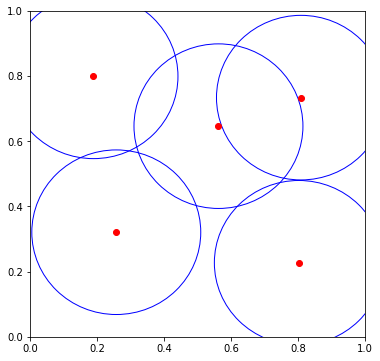

In [272]:
plot_lamps(groups_xy[0][1], problem_size)

In [278]:
lamp_grid = create_lamp_grid(grid_size, problem_size)
calculate_areas(groups_xy[0][1], grid_size, problem_size, lamp_grid)

(0.837584, 0.162416)